### Tag 13

Die Normandie ist weltweit bekannt für ihre historische Bedeutung, insbesondere im Zusammenhang mit dem Zweiten Weltkrieg. In dieser Region gibt es unzählige Gedenkstätten, Museen und Denkmäler, die an die Ereignisse des D-Day und die Befreiung Europas erinnern. Als Data Scientist fasziniert mich die Möglichkeit, Daten aus der realen Welt automatisiert zu erfassen und zu analysieren, insbesondere an solch geschichtsträchtigen Orten.

Ein Gedanke, der mir dabei kam, ist die Idee, Gedenkstätten mithilfe von Bilddaten automatisch auszumessen und zu dokumentieren. Um den Einstieg zu erleichtern, habe ich mich entschieden, ein einfaches Beispiel zu nehmen: die Analyse von Flaggen, die an einer Gedenkstätte wehen. Konkret werde ich ein Bild von Flaggen an der Gedenkstätte von Omaha Beach verwenden, einem der zentralen Orte der Landung der Alliierten im Jahr 1944.

Mein Plan ist es, die Flaggen auf dem Bild zu segmentieren, das heißt, sie visuell vom Hintergrund zu trennen, und anschließend Berechnungen durchzuführen. Wie die Höhe der Flaggenmasten, den Abstand zwischen den einzelnen Flaggen sowie die Neigungswinkel der Flaggen durch den Einfluss des Windes umfassen (wenn möglich). Solche Analysen könnten nicht nur für die Vermessung einzelner Objekte genutzt werden, sondern auch als Grundlage dienen, um größere Datensätze von Gedenkstätten systematisch zu erfassen und zu vergleichen.

(Text wurde mit Perplexity verbessert)

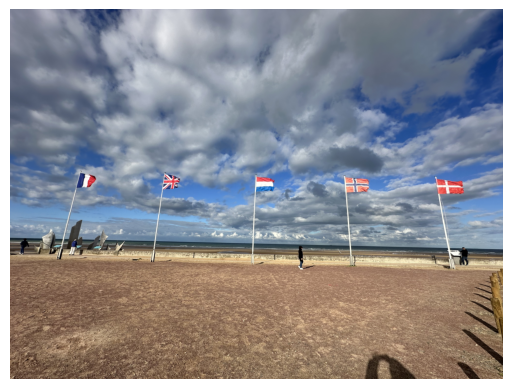

In [1]:
# Bild einfügen
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('IMG_1470_converted.png')

# Bild ploten
plt.imshow(image)
plt.axis('off') 
plt.show()

### Tag 14

Da es etwas schwierig ist, die Flaggen von den Wolken zu trennen, werde ich das Bild zuerst zuschneiden, sodass der Himmel etwas abgeschnitten ist.

Ich werde nun mithilfe von OpenCV versuchen die Flaggen auf dem Bild zu segmentieren. Dazu werde ich die Farbe der Flaggen verwenden, um sie vom Hintergrund zu trennen. Ich werde die Farbe der Flaggen in den HSV-Farbraum konvertieren und dann einen Schwellenwert anwenden, um die Flaggen zu isolieren. ich fokussiere mich hier vor allem auf doe roten Bereiche der Flaggen und kann somit besser die Bereiche im Himmel ausschliessen.

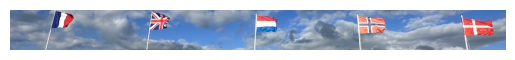

In [2]:
image_cut = Image.open('IMG_1470_converted_cut.png')

plt.imshow(image_cut)
plt.axis('off')
plt.show()

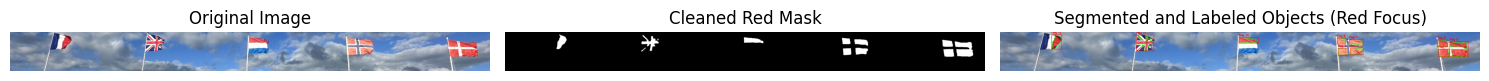

Flag 1: Position=(3244, 130), Width=80, Height=56
Flag 2: Position=(2501, 124), Width=61, Height=50
Flag 3: Position=(2593, 121), Width=93, Height=49
Flag 5: Position=(3328, 76), Width=136, Height=110
Flag 6: Position=(3236, 64), Width=78, Height=50
Flag 7: Position=(2585, 60), Width=101, Height=48
Flag 9: Position=(2494, 50), Width=62, Height=45
Flag 10: Position=(1768, 46), Width=144, Height=42
Flag 11: Position=(1010, 29), Width=128, Height=115
Flag 12: Position=(381, 26), Width=75, Height=105


In [3]:
import cv2
import numpy as np

# Bild laden
image_path = 'IMG_1470_converted_cut.png'  # Pfad zum Bild
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Konvertiere das Bild in den HSV-Farbraum
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Definiere Farbgrenzen für Rot (zwei Bereiche wegen HSV-Wrap-Around)
lower_red1 = np.array([0, 50, 50])  # Weniger Sättigung für robustere Erkennung
upper_red1 = np.array([15, 255, 255])
lower_red2 = np.array([165, 50, 50])
upper_red2 = np.array([180, 255, 255])
red_mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
red_mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)

# Kombiniere die roten Masken
red_mask = cv2.bitwise_or(red_mask1, red_mask2)

# Morphologische Operationen zur Maskenbereinigung
kernel = np.ones((5, 5), np.uint8)
cleaned_red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
cleaned_red_mask = cv2.morphologyEx(cleaned_red_mask, cv2.MORPH_OPEN, kernel, iterations=1)

# Finde Konturen basierend auf der bereinigten roten Maske
contours, _ = cv2.findContours(cleaned_red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Bereite das Bild zur Beschriftung vor
labeled_image = image_rgb.copy()
flag_properties = []

for i, contour in enumerate(contours):
    if cv2.contourArea(contour) > 500:  # Filtere kleine Konturen heraus
        # Zeichne die Kontur
        cv2.drawContours(labeled_image, [contour], -1, (0, 255, 0), 2)
        
        # Berechne die Bounding Box und zeichne sie
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(labeled_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Speichere Eigenschaften der Flaggen
        flag_properties.append({
            "ID": i + 1,
            "Position": (x, y),
            "Width": w,
            "Height": h
        })
        cv2.putText(labeled_image, f"Flag {i + 1}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Ergebnisse anzeigen
plt.figure(figsize=(15, 10))

# Originalbild
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis("off")

# Bereinigte rote Maske
plt.subplot(1, 3, 2)
plt.title("Cleaned Red Mask")
plt.imshow(cleaned_red_mask, cmap="gray")
plt.axis("off")

# Segmentierte und gelabelte Objekte
plt.subplot(1, 3, 3)
plt.title("Segmented and Labeled Objects (Red Focus)")
plt.imshow(labeled_image)
plt.axis("off")

plt.tight_layout()
plt.show()

# Ausgabe der Flaggen-Eigenschaften
for flag in flag_properties:
    print(f"Flag {flag['ID']}: Position={flag['Position']}, Width={flag['Width']}, Height={flag['Height']}")



Man erkennt hier gut, dass die letzten beiden Flaggen schon sehr gut erkannt wurden. Bei der ersten Flagge wurde leider nur der rechte Teil erkannt, da die Flagge nur rechts rot ist. Die zweite wurde auch recht gut erkannt, diese ist vom Wind etwas abgeschnitten, wodurch sie eben rechts unten nicht gut erkannt wurde. Die dritte Flagge wurde nur oben erkannt, da hier der untere Teil kein rot enthält.

Ich werde jetzt noch mithilfe von Canny-Kantendetektion versuchen die französische und holländische Flagge besser zu erkennen.

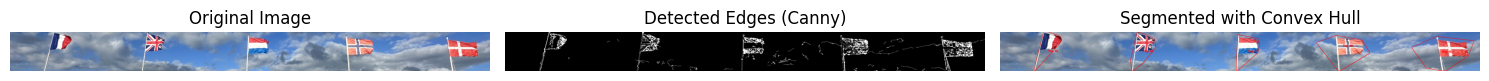

Flag 45: Center=(3269, 165), Width=454, Height=243, Angle=6.34
Flag 46: Center=(2538, 122), Width=264, Height=304, Angle=59.61
Flag 47: Center=(1834, 161), Width=165, Height=261, Angle=2.98
Flag 48: Center=(1059, 162), Width=161, Height=283, Angle=13.64
Flag 49: Center=(356, 160), Width=144, Height=301, Angle=15.17


In [4]:
# Konvertiere das Bild in Graustufen
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Canny-Kantendetektion
edges = cv2.Canny(gray_image, 50, 150)

# Morphologische Operationen zur Rauschunterdrückung
kernel = np.ones((3, 3), np.uint8)
cleaned_edges = cv2.dilate(edges, kernel, iterations=1)
cleaned_edges = cv2.erode(cleaned_edges, kernel, iterations=1)

# Finde Konturen in den Kanten
contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Bild zur Beschriftung vorbereiten
labeled_image = image_rgb.copy()
flag_properties = []

for i, contour in enumerate(contours):
    if cv2.contourArea(contour) > 500:  # Filter für kleinere Konturen
        # Berechne die konvexe Hülle der Kontur
        hull = cv2.convexHull(contour)

        # Optional: Minimal umschließendes Rechteck berechnen
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

        # Zeichne die konvexe Hülle und die minimal umschließende Box
        cv2.drawContours(labeled_image, [hull], 0, (255, 0, 0), 2)

        # Speichere Eigenschaften der Flagge
        flag_properties.append({
            "ID": i + 1,
            "Center": (int(rect[0][0]), int(rect[0][1])),
            "Width": int(rect[1][0]),
            "Height": int(rect[1][1]),
            "Angle": round(rect[2], 2)
        })
        cv2.putText(labeled_image, f"Flag {i + 1}", (int(rect[0][0]), int(rect[0][1] - 10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Ergebnisse anzeigen
plt.figure(figsize=(15, 10))

# Originalbild
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis("off")

# Kantenbild
plt.subplot(1, 3, 2)
plt.title("Detected Edges (Canny)")
plt.imshow(cleaned_edges, cmap="gray")
plt.axis("off")

# Beschriftetes Bild
plt.subplot(1, 3, 3)
plt.title("Segmented with Convex Hull")
plt.imshow(labeled_image)
plt.axis("off")

plt.tight_layout()
plt.show()

# Ausgabe der Flaggen-Eigenschaften
for flag in flag_properties:
    print(f"Flag {flag['ID']}: Center={flag['Center']}, Width={flag['Width']}, Height={flag['Height']}, Angle={flag['Angle']}")

Mit der Canny-Detektion hat es sogar noch besser funktioniert. Man erkennt im mitlleren Plot sehr gut, dass die Flaggen sehr gut erkannt wurden. Ich habe dann noch versucht eine Boundingbox um die Flaggen zu zeichnen, das hat leider nicht so gut funktioniert, wie ich es mir vorgestellt habe. Hier werden zu den Flaggen auch noch die Stäbe erkennt und vor allem bei den letzten beiden Flaggen wird auch noch der Himmel erkannt.

An den Eigenschaften erkannt man auch gut, dass nur die fünf Flaggen erkannt wurden, bei der ersten Methode wurden 10 Labels erkannt.

(Copilot wurde bei der Erstellung beider Ansätze verwendet)

### Tag 15
 
Als nächstes werde ich verschiedene morphologische Veränderungen ausprobieren, um die Qualität der Maske weiter zu verbessern. Ich habe Closing angewendet, um kleine Lücken in den Objekten zu schließen, und Opening, um Rauschen zu entfernen. Mit Dilatation und Erosion habe ich die Kanten geglättet und die Form der Objekte konsistent gehalten. Zusätzlich habe ich Top-Hat- und Black-Hat-Transformationen verwendet, um helle und dunkle Details hervorzuheben, die durch den Hintergrund maskiert sein könnten. Mein Ziel ist es, eine präzisere und optimierte Maske zu erstellen, die meine Flaggenerkennung besser macht.

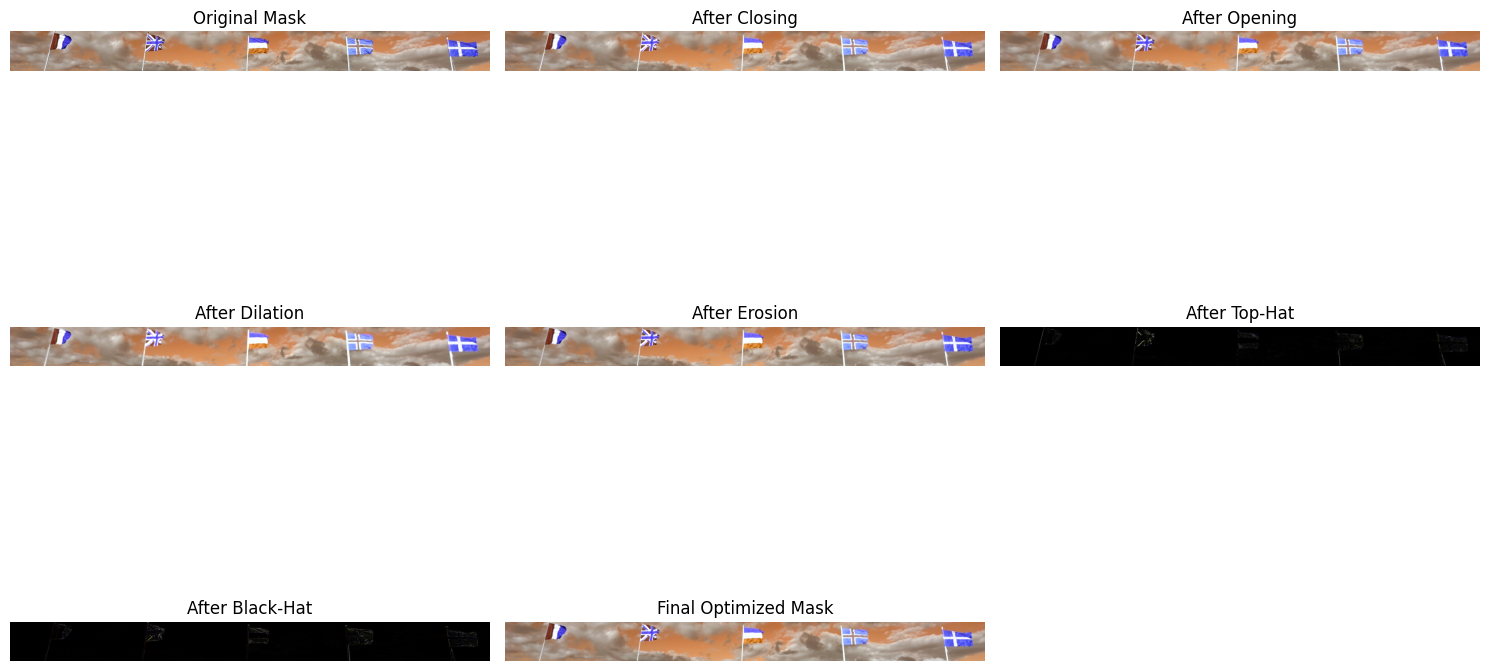

In [5]:
# Originalmaske
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
plt.title("Original Mask")
plt.imshow(image, cmap='gray')
plt.axis("off")

# Morphologische Operationen
kernel = np.ones((5, 5), np.uint8)

# 1. Closing 
closed_mask = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
plt.subplot(3, 3, 2)
plt.title("After Closing")
plt.imshow(closed_mask, cmap='gray')
plt.axis("off")

# 2. Opening 
opened_mask = cv2.morphologyEx(closed_mask, cv2.MORPH_OPEN, kernel)
plt.subplot(3, 3, 3)
plt.title("After Opening")
plt.imshow(opened_mask, cmap='gray')
plt.axis("off")

# 3. Dilatation
dilated_mask = cv2.dilate(opened_mask, kernel, iterations=1)
plt.subplot(3, 3, 4)
plt.title("After Dilation")
plt.imshow(dilated_mask, cmap='gray')
plt.axis("off")

# 4. Erosion 
eroded_mask = cv2.erode(dilated_mask, kernel, iterations=1)
plt.subplot(3, 3, 5)
plt.title("After Erosion")
plt.imshow(eroded_mask, cmap='gray')
plt.axis("off")

# 5. Top-Hat 
tophat_mask = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
plt.subplot(3, 3, 6)
plt.title("After Top-Hat")
plt.imshow(tophat_mask, cmap='gray')
plt.axis("off")

# 6. Black-Hat 
blackhat_mask = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)
plt.subplot(3, 3, 7)
plt.title("After Black-Hat")
plt.imshow(blackhat_mask, cmap='gray')
plt.axis("off")

# Finale optimierte Maske (optional kombinieren)
final_mask = cv2.morphologyEx(eroded_mask, cv2.MORPH_CLOSE, kernel)
plt.subplot(3, 3, 8)
plt.title("Final Optimized Mask")
plt.imshow(final_mask, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()

Bei der Finalen Maske habe ich am Schluss noch ein Closing hinzugefügt, um verbleibende Lücken innerhalb der Objekte zu schließen und sicherzustellen, dass zusammenhängende Bereiche vollständig verbunden sind. Dadurch wurde die Maske weiter geglättet und kleine Unregelmäßigkeiten beseitigt, während die ursprüngliche Form und Größe der Objekte erhalten blieb. 
Ich habe hier nicht weiter mit der Back-Hat und Top-Hat gearbeitet, da hier die Flaggen so gut wie nicht merh erkannt wurden.

### Tag 16

1. Parameter: Ich habe überall einen 5x5-Kernel gewählt, da dieser eine gute Balance zwischen Detailerhaltung und Effektivität bietet, um kleine Störungen zu entfernen oder Lücken zu schließen, ohne die Objekte signifikant zu verändern.

2. Closing: Closing wurde angewendet, um kleine Lücken innerhalb der Objekte zu schließen und benachbarte Pixelregionen zu verbinden. Dadurch wird sichergestellt, dass die Flaggen in der Maske vollständig verbunden dargestellt werden.

2. Opening: Opening wurde verwendet, um kleinere Rauschpixel zu entfernen, die möglicherweise durch falsch erkannte Bereiche in der Maske entstanden sind. Dies hilft, die Maske zu bereinigen und sich auf die tatsächlichen Objekte zu konzentrieren.

3. Dilatation: Dilatation wurde verwendet, um die Kanten der Objekte in der Maske leicht zu erweitern und sicherzustellen, dass diese vollständig erfasst werden. Es hilft auch, kleinere Unterbrechungen in den Kanten zu füllen.

4. Erosion: Erosion wurde nach der Dilatation angewendet, um die zuvor erweiterten Bereiche wieder auf ihre ursprüngliche Größe zurückzuführen. Dies stellt sicher, dass die Form der Objekte möglichst originalgetreu bleibt.

5. Top-Hat: Top-Hat wurde verwendet, um kleine, helle Details hervorzuheben, die von dunkleren Umgebungen umgeben sind. Dies könnte helfen, spezifische Merkmale der Flaggen zu erkennen, falls diese durch Hintergrundmasken verdeckt sind.

6. Black-Hat: Black-Hat wurde verwendet, um dunkle Bereiche hervorzuheben, die von helleren Umgebungen umgeben sind. Dies kann hilfreich sein, um Details wie dunkle Streifen oder Übergänge in der Flagge sichtbar zu machen.

7. Finales Bild: Am Ende wurde Closing erneut angewendet, um sicherzustellen, dass verbleibende Lücken in den Objekten geschlossen werden. Dadurch wird die finale Maske konsistenter und benachbarte Bereiche vollständig verbunden.

### Tag 17

Ich werde nun die Flaggen aus dem überarbeiteten Bild extrahieren und die charakteristischen Eigenschaften wie Fläche, Seitenverhältnis und Schwerpunkt untersuchen, um die Grösse, Form und Position zu analysieren. Diese Informationen könnten nützlich sein, um die Flaggen weiter zu klassifizieren oder zu identifizieren, basierend auf ihren visuellen Merkmalen.

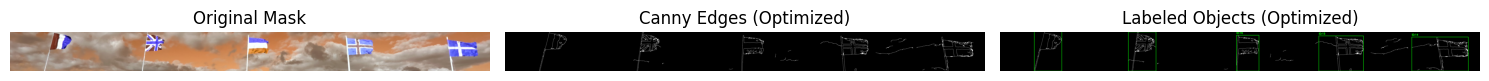

,ID,Area,Aspect_Ratio,Centroid
0,14,23390.0,1.70,"(3344, 129)"
1,15,18692.5,1.30,"(2591, 111)"
2,16,9974.0,0.64,"(1834, 108)"
3,17,13392.0,0.72,"(1063, 88)"
4,18,10027.0,0.71,"(367, 79)"


In [6]:
import pandas as pd

# Canny-Kantendetektion
edges = cv2.Canny(final_mask, 70, 200) 

# Morphologische Operationen zur Bereinigung der Kanten
kernel = np.ones((3, 3), np.uint8)  # Kleinerer Kernel für Präzision
cleaned_edges = cv2.dilate(edges, kernel, iterations=1)  # Verbindet Kanten
cleaned_edges = cv2.erode(cleaned_edges, kernel, iterations=1)  # Glättet Kanten

# Finde Konturen in den bereinigten Kanten
contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Eigenschaften der Objekte
object_properties = []
labeled_image = cv2.cvtColor(cleaned_edges, cv2.COLOR_GRAY2BGR)

for i, contour in enumerate(contours):
    # Filtere kleine Objekte basierend auf Fläche und Seitenverhältnis
    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / h
    if area > 1000 and 0.3 < aspect_ratio < 3.0:  # Größe und Formfilter
        # Berechne Schwerpunkt
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0

        # Speichere Eigenschaften
        object_properties.append({
            "ID": i + 1,
            "Area": area,
            "Aspect_Ratio": round(aspect_ratio, 2),
            "Centroid": (cx, cy)
        })

        # Zeichne Bounding-Box und Beschriftung
        cv2.rectangle(labeled_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(labeled_image, f"ID:{i + 1}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Ergebnisse anzeigen
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.title("Original Mask")
plt.imshow(final_mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Canny Edges (Optimized)")
plt.imshow(cleaned_edges, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Labeled Objects (Optimized)")
plt.imshow(labeled_image)
plt.axis("off")
plt.tight_layout()
plt.show()

# Eigenschaften der Objekte in einer Tabelle darstellen
object_df = pd.DataFrame(object_properties)
object_df

Es funktioniert leider nicht perfekt, dass nur die Flaggen erkannt werden aber ich habe dennoch die Werte berechnet. Area ist die Fläche der Flagge in Pixeln, Aspect_Ratio ist das Verhältnis von Breite zu Höhe, welches die Form charakterisiert und Centroid sind die Koordinaten der Flagge im Schwerpunkt, um die Positionierung zu erkennen.

Die extrahierten Objekte zeigen deutliche Unterschiede in ihrer Fläche, wobei größere Werte wie 23390 (ID 14) und 18692.5 (ID 15) auf größere Flaggen im Bild hinweisen (die Flaggen mit der zu grossen Bounding-Box). Das Seitenverhältnis der Objekte liegt überwiegend im Bereich von 0.64 bis 1.70, was auf rechteckige Formen hinweist, wobei kleinere Werte auf schmalere oder hochformatige Flaggen deuten (der Stab wird hier leider mit gemessen, darum stimmt dies ebenfalls nicht ganz überein). Die Schwerpunkte zeigen eine Verteilung über das Bild, was darauf hinweist, dass die Flaggen in unterschiedlichen Bereichen des Bildes korrekt lokalisiert wurden. Ganz links im Bild ist ID 18, dann ID 17, ID 16, ID 15 und ID 14. Das stimmt auch mit meiner Vermutung überein über die grossen Flächen bei ID 14 und 15.

(Copilot wurde beim erstellen des Codes verwendet)

### Tag 18

Als nächstes möchte ich nun aus einem Objekt das Skeleton extrahieren. Ich habe mich hier für ID 16 entschieden, da hier die Bounding-Box am besten an der Flagge angepasst ist. Um das Skeleton zu extrahieren, habe ich die Maske für ID 16 isoliert und anschließend mithilfe morphologischer Erosionen das Objekt schrittweise reduziert, bis nur noch die minimale zusammenhängende Struktur, also das Skeleton, übrig blieb.

Das Skeleton zeigt die essenzielle Form der Flagge, indem es die Objektstruktur auf eine einzelne Linie reduziert. Zusätzlich wurde die Anzahl der Pixel im Skeleton berechnet, um die Komplexität des Objekts quantitativ zu erfassen. 

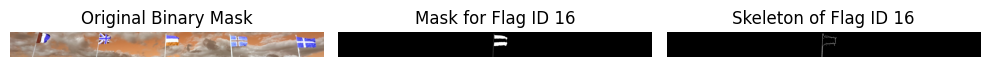

Anzahl der Pixel im Skeleton für die Flagge mit ID 16: 862


In [7]:
# Eigenschaften berechnen und ID == 16 auswählen
object_contour = None
for i, contour in enumerate(contours):
    # Berechne Bounding Box und Schwerpunkt
    x, y, w, h = cv2.boundingRect(contour)
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0

    # Prüfe die Position für ID == 16
    if (cx, cy) == (1834, 108):  # Schwerpunkt aus der Tabelle für ID 16
        object_contour = contour
        break

# Erstelle eine neue Maske für die Flagge mit ID == 16
single_object_mask = np.zeros(final_mask.shape[:2], dtype=np.uint8)
if object_contour is not None:
    cv2.drawContours(single_object_mask, [object_contour], -1, 255, thickness=cv2.FILLED)

# Skelettierung der ausgewählten Flagge
skeleton = np.zeros_like(single_object_mask)
kernel = np.ones((3, 3), np.uint8)

temp_mask = single_object_mask.copy()
while True:
    eroded = cv2.erode(temp_mask, kernel)  # Erosion anwenden
    temp_dilated = cv2.dilate(eroded, kernel)  # Dilatation auf das Erodierte
    temp = cv2.subtract(temp_mask, temp_dilated)  # Differenz (Kantenreste)
    skeleton = cv2.bitwise_or(skeleton, temp)  # Skeleton aktualisieren
    temp_mask = eroded.copy()
    
    if cv2.countNonZero(temp_mask) == 0:
        break

# Anzahl der Skeleton-Pixel berechnen
skeleton_pixel_count = cv2.countNonZero(skeleton)
skeleton = cv2.dilate(skeleton, kernel, iterations=1)

# Ergebnisse anzeigen
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Binary Mask")
plt.imshow(final_mask)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Mask for Flag ID 16")
plt.imshow(single_object_mask, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Skeleton of Flag ID 16")
plt.imshow(skeleton, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Anzahl der Pixel im Skeleton für die Flagge mit ID 16: {skeleton_pixel_count}")

Das extrahierte Skeleton stellt die mittlere Flagge zusammen mit dem Mast präzise dar. Es reduziert die Struktur der Flagge auf ihre essenzielle Form und zeigt die zentralen Linien der Flagge und des Masts deutlich.

Als nächstes möchte ich mithilfe des Skeletons die Seitenlänge meiner Flagge berechnen. Dazu werde ich die Eckpunkte des Skeletons bestimmen und die Distanz zwischen den äußersten Punkten messen. Dies gibt mir eine Schätzung der Länge der Flagge entlang des Skeletons. Wenn man nun ebenfalls ein Objekt im Bild hat, wo man die Grösse in cm kennt, kann man die Grösse der Flagge in Pixeln in cm umrechnen.

In [12]:
from scipy.spatial.distance import euclidean

# Skeleton Linienlänge berechnen
skeleton_length = 0
skeleton_points = cv2.findNonZero(skeleton)
if skeleton_points is not None:
    for i in range(1, len(skeleton_points)):
        skeleton_length += cv2.norm(skeleton_points[i - 1], skeleton_points[i], cv2.NORM_L2)
        
print(f"Länge des Skeletons für die Flagge mit ID 16: {skeleton_length:.2f} Pixel")

# Skeleton Eckpunkte der Flagge mit ID == 16 finden
corners = cv2.goodFeaturesToTrack(skeleton, 4, 0.01, 10)
corners = np.int64(corners)

# Ergebnisse anzeigen
skeleton_corners = image_rgb.copy()
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(skeleton_corners, (x, y), 5, (255, 0, 0), -1)
    
# Endpunkte printen
for i, corner in enumerate(corners):
    print(f"Endpunkt {i + 1}: {tuple(corner.ravel())}")

# Pixellänge zwischen den Endpunkten berechnen
# Berechne die Euklidische Distanz zwischen allen Eckpunkten
side_lengths = []
num_points = len(corners)

for i in range(num_points):
    point1 = corners[i].ravel()
    point2 = corners[(i + 1) % num_points].ravel()  # Verbindung zum nächsten Punkt (geschlossenes Rechteck)
    length = euclidean(point1, point2)
    side_lengths.append(length)
    print(f"Länge zwischen Punkt {i+1} {point1} und Punkt {(i+2) % num_points} {point2}: {length:.2f} Pixel")

Länge des Skeletons für die Flagge mit ID 16: 31515.25 Pixel
Endpunkt 1: (np.int64(1840), np.int64(158))
Endpunkt 2: (np.int64(1772), np.int64(156))
Endpunkt 3: (np.int64(1841), np.int64(147))
Endpunkt 4: (np.int64(1879), np.int64(133))
Länge zwischen Punkt 1 [1840  158] und Punkt 2 [1772  156]: 68.03 Pixel
Länge zwischen Punkt 2 [1772  156] und Punkt 3 [1841  147]: 69.58 Pixel
Länge zwischen Punkt 3 [1841  147] und Punkt 0 [1879  133]: 40.50 Pixel
Länge zwischen Punkt 4 [1879  133] und Punkt 1 [1840  158]: 46.32 Pixel


Ich habe hier wie erwartet vier Punkte gefunden, welche auch realistisch sind, da ich den Schwerpunkt der Flagge weiter oben berechnet habe und diese Punkte um den Schwerpunkt liegen. Die Distanz zwischen den Punkten ist auch realistisch, da die Flagge nicht gerade ist und somit die Distanz zwischen den Punkten nicht gleich ist.

### Tag 19

Mein Ziel war es, eine Methode zu entwickeln, um berühmte Gedenkstätten in der Normandie automatisch zu vermessen und zu analysieren. Als Ausgangspunkt habe ich ein Bild von Flaggen an der Gedenkstätte von Omaha Beach verwendet. Mithilfe von Bildverarbeitungstechniken wollte ich die Flaggen segmentieren und analysieren.

Aufgrund der Farbähnlichkeiten zwischen den Flaggen und dem wolkenverhangenen Himmel war es zunächst nicht möglich, die Flaggen im gesamten Bild zuverlässig zu erkennen. Um dieses Problem zu lösen, habe ich das Bild zugeschnitten, um den relevanten Bereich mit den Flaggen besser hervorzuheben. Für die Segmentierung entschied ich mich gezielt für Farbsegmentierung im HSV-Farbraum, da dieser im Vergleich zum RGB-Farbraum weniger anfällig für Beleuchtungsschwankungen ist. Die rote Farbe der Flaggen wurde als Fokus gewählt, weil sie einen stärkeren Kontrast zum Himmel und zu anderen Hintergrundelementen bietet. Hierbei habe ich zwei Bereiche für die Rottöne im HSV-Farbraum definiert – einmal für helle und einmal für dunklere Rottöne – um Farbabweichungen durch Beleuchtungseinflüsse besser abzufangen.

Anschließend habe ich die Bildqualität mithilfe von morphologischen Operationen optimiert und das Skeleton einer einzelnen Flagge extrahiert. Dieses Skeleton ermöglichte mir eine genauere Analyse der Flagge, inklusive der Berechnung der Seitenlängen und der Bestimmung der Größe in Pixeln.

Zwar habe ich beim Aufnehmen des Bildes versäumt, eine Referenzgröße mitzunehmen, um die tatsächlichen Abmessungen der Flagge in Zentimetern zu bestimmen, dennoch bin ich mit meinen Ergebnissen zufrieden. Der Prozess hat gezeigt, dass es möglich ist, Gedenkstätten mithilfe von Bildverarbeitungstechniken zu analysieren und zu vermessen – ein erster Schritt in Richtung automatisierter Analysen in der Normandie.

(Text wurde mit Perplexity verbessert)